# Simulator PV Valle_de_la_Luna_II

- Author: Victor Muñoz
- Collaborator: Nicolás Otárola
- Pvlib_version: 0.6.3
- Date : 06-01-2022 

In [1]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Photovoltaic systems
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

# functions AND system photovoltaic
import sys
sys.path.append('../')
sys.path.append('../../')

import funciones as func
import Valle_de_la_Luna_II as pv

import imp
imp.reload(pv)
imp.reload(func)

# save graphics
%matplotlib inline
%matplotlib notebook



## 1) Location , Module, Inverter, System and Model

In [2]:
#Location
loc = Location(latitude=pv.Location['lat'],
               longitude=pv.Location['long'],
               tz=pv.Location['tz'],
               altitude=pv.Location['alt'])

In [3]:
#module
module_325 = pd.Series(pv.JAM60S03,
                       name=pv.JAM60S03['Name'])

In [4]:
#inverter
inverter_1600_A = pd.Series(pv.MV_Power_Station_1600SC,
                            name=pv.MV_Power_Station_1600SC['Name'])
inverter_1600_B = pd.Series(pv.MV_Power_Station_1600SC,
                            name=pv.MV_Power_Station_1600SC['Name'])

In [5]:
#System
system_A = PVSystem(module_parameters=module_325,
                    inverter_parameters=inverter_1600_A,
                    surface_azimuth=pv.System['azimuth'],
                    surface_tilt=pv.System['tilt'],
                    modules_per_string=pv.System['m_p_s'],
                    strings_per_inverter=pv.System['s_p_i'])

system_B = PVSystem(module_parameters=module_325,
                    inverter_parameters=inverter_1600_B,
                    surface_azimuth=pv.System['azimuth'],
                    surface_tilt=pv.System['tilt'],
                    modules_per_string=pv.System['m_p_s'],
                    strings_per_inverter=pv.System['s_p_i'])

In [6]:
#model
mc_A = ModelChain(system_A, loc, 
                  aoi_model= 'physical' ,      # physical
                  spectral_model="no_loss",    # no_loss
                  dc_model='cec',              # cec or pvwatts
                  ac_model = 'pvwatts',        # snlinverter by pvwatts
                  temp_model='sapm',           # sapm
                  losses_model="pvwatts",      # pvwatts
                  name="system_A")             # system_A

mc_B = ModelChain(system_B, loc,
                  aoi_model="physical",        # physical
                  spectral_model="no_loss",    # no_loss
                  dc_model='cec',              # cec or pvwatts
                  ac_model = 'pvwatts',        # snlinverter by pvwatts
                  temp_model='sapm',           # sapm
                  losses_model="pvwatts",      # pvwatts
                  name="system_B")             # system_B

## 2) Data Weather Solcast and Generacion solar

In [7]:
# Weather Solcast
path = '../solcast/-25.406494_-70.480303_Solcast_PT60M.csv'
solcast = func.weather_solcast(path)
times, weather = func.get_times_weather(solcast,loc)

In [15]:
# Generacion solar

# Leer excel para generar pickle.
#name_excel = 'Generacion MWh plantas solar.xlsx'
#excel = pd.read_excel(name_excel)
#excel.to_pickle("Generacion MWh plantas solar")

# Leer picke una vez ya creado
data_pickle = pd.read_pickle('../Generacion MWh plantas solar')
name_pv = 'PMGD PFV VALLE DE LA LUNA II'
data_sub = data_pickle.loc[data_pickle['Central'] == name_pv]

In [9]:
data = func.filter_day_by_year(2020, data_sub)
data = [x*100 for x in data['Total']]

## 3) Simulate

In [10]:
# Run model
mc_A.run_model(times=times, weather=weather)
mc_B.run_model(times=times, weather=weather)

/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/solarposition.py:347: FutureWarning: casting datetime64[ns, America/Santiago] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  unixtime = np.array(time.astype(np.int64)/10**9)
/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/singlediode.py:425: RuntimeWarning: invalid value encountered in true_divide
  V[idx_z] = a[idx_z] * np.log1p((IL[idx_z] - I[idx_z]) / I0[idx_z]) - \
/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/singlediode.py:433: RuntimeWarning: invalid value encountered in multiply
  argW = (I0[idx_p] / (Gsh[idx_p] * a[idx_p]) *
/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/singlediode.py:447: RuntimeWarning: divide by zero encountered in log
  logargW = (np.log(I0[idx_p]) - np.log(Gsh[idx_p]) -
/Users/nicolasotarolate

ModelChain: 
  name: system_B
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: pvwatts_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses

## 4) Graphics

<IPython.core.display.Javascript object>


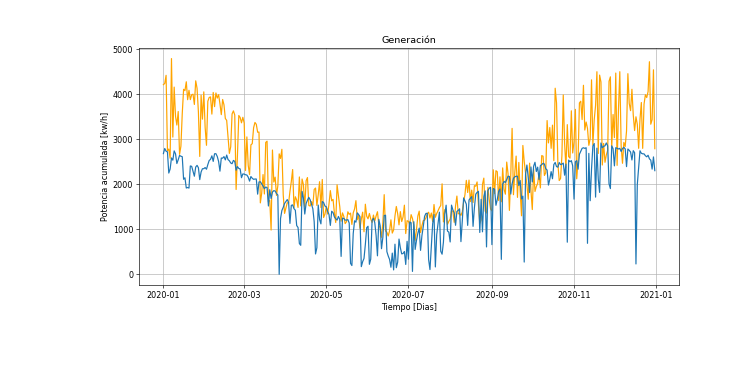

In [11]:
x_d ,y_d_a = func.get_daily_axes_from_modelChain_object(mc_A, 'System_A')
_ ,y_d_b = func.get_daily_axes_from_modelChain_object(mc_B, 'System_B')

y_d = [a+b for a,b in zip(y_d_a,y_d_b)]

func.plot(x=x_d,
          y=y_d,
          y2=data,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_dias',
          color='orange',
          title='Generación',
          x_label='Tiempo [Dias]',
          y_label='Potencia acumulada [kw/h]')


In [90]:
def filter_hour_by_year(data_sub, year):
    #names = [i for i in data_sub]
    names = ['Fecha', 'Hora 1', 'Hora 2', 'Hora 3', 'Hora 4', 'Hora 5', 'Hora 6', 'Hora 7', 'Hora 8', 'Hora 9', 'Hora 10', 'Hora 11', 'Hora 12', 'Hora 13', 'Hora 14', 'Hora 15', 'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19', 'Hora 20', 'Hora 21', 'Hora 22', 'Hora 23', 'Hora 24']
    #print(names)
    filter_data = data_sub.loc[data_sub['año'] == year]
    #print(filter_data)
    long = len(filter_data)
    days = []
    arr = []
    for i in range(long):
        for j in range(len(names)):
            if (names[j] == 'Fecha'):
                f = filter_data['Fecha'].iloc[i]
                
            else:
                h = names[j]
                print(f)
                print(h)
                v = filter_data[names[j]].iloc[i]
                print(v)
                
                #days.append()
                #valor = filter_data[names[j]].iloc[i]
                #dic[filter_data['Fecha'].iloc[i]].append()
                #print(filter_data[names[j]].iloc[i])

        
filter_hour_by_year(data_sub,2020)

2020-01-01
Hora 1
0.0
2020-01-01
Hora 2
0.0
2020-01-01
Hora 3
0.0
2020-01-01
Hora 4
0.0
2020-01-01
Hora 5
0.0
2020-01-01
Hora 6
0.0
2020-01-01
Hora 7
0.0020738738
2020-01-01
Hora 8
0.3906568031
2020-01-01
Hora 9
1.6380394592
2020-01-01
Hora 10
2.2588677369
2020-01-01
Hora 11
2.4453600464
2020-01-01
Hora 12
2.4996051636
2020-01-01
Hora 13
2.5136452027
2020-01-01
Hora 14
2.5742630615
2020-01-01
Hora 15
2.5851517334
2020-01-01
Hora 16
2.5790015869
2020-01-01
Hora 17
2.5196383057
2020-01-01
Hora 18
1.582563919
2020-01-01
Hora 19
2.0130280152
2020-01-01
Hora 20
1.1053015747
2020-01-01
Hora 21
0.118544987
2020-01-01
Hora 22
0.0
2020-01-01
Hora 23
0.0
2020-01-01
Hora 24
0.0
2020-01-02
Hora 1
0.0
2020-01-02
Hora 2
0.0
2020-01-02
Hora 3
0.0
2020-01-02
Hora 4
0.0
2020-01-02
Hora 5
0.0
2020-01-02
Hora 6
0.0
2020-01-02
Hora 7
0.0030218575
2020-01-02
Hora 8
0.4195297375
2020-01-02
Hora 9
1.6697110901
2020-01-02
Hora 10
2.3054127197
2020-01-02
Hora 11
2.4751331787
2020-01-02
Hora 12
2.5280014037
202

0.0
2020-01-16
Hora 8
0.1321199188
2020-01-16
Hora 9
0.7744659119
2020-01-16
Hora 10
1.498151245
2020-01-16
Hora 11
1.9269349671
2020-01-16
Hora 12
2.1247086182
2020-01-16
Hora 13
2.1778869019
2020-01-16
Hora 14
2.1923697509
2020-01-16
Hora 15
2.2138237915
2020-01-16
Hora 16
2.1820708009
2020-01-16
Hora 17
2.0700663757
2020-01-16
Hora 18
1.8236201783
2020-01-16
Hora 19
1.3531854858
2020-01-16
Hora 20
0.5928285141
2020-01-16
Hora 21
0.0525037131
2020-01-16
Hora 22
0.0
2020-01-16
Hora 23
0.0
2020-01-16
Hora 24
0.0
2020-01-17
Hora 1
0.0
2020-01-17
Hora 2
0.0
2020-01-17
Hora 3
0.0
2020-01-17
Hora 4
0.0
2020-01-17
Hora 5
0.0
2020-01-17
Hora 6
0.0
2020-01-17
Hora 7
1.504e-06
2020-01-17
Hora 8
0.1659021568
2020-01-17
Hora 9
0.8781079406
2020-01-17
Hora 10
1.6616556701
2020-01-17
Hora 11
2.0305306396
2020-01-17
Hora 12
2.0009677123
2020-01-17
Hora 13
2.092067871
2020-01-17
Hora 14
2.2436624145
2020-01-17
Hora 15
2.2555166626
2020-01-17
Hora 16
2.2173915405
2020-01-17
Hora 17
2.0831047058
2020-

Hora 10
2.1761892701
2020-02-07
Hora 11
2.4164425659
2020-02-07
Hora 12
2.4693153077
2020-02-07
Hora 13
2.4729534302
2020-02-07
Hora 14
1.3154806945
2020-02-07
Hora 15
2.4859682007
2020-02-07
Hora 16
2.5066828003
2020-02-07
Hora 17
2.5323479614
2020-02-07
Hora 18
2.4607614746
2020-02-07
Hora 19
2.1368262939
2020-02-07
Hora 20
0.9307838821
2020-02-07
Hora 21
0.0557567141
2020-02-07
Hora 22
0.0
2020-02-07
Hora 23
0.0
2020-02-07
Hora 24
0.0
2020-02-08
Hora 1
0.0
2020-02-08
Hora 2
0.0
2020-02-08
Hora 3
0.0
2020-02-08
Hora 4
0.0
2020-02-08
Hora 5
0.0
2020-02-08
Hora 6
0.0
2020-02-08
Hora 7
0.0
2020-02-08
Hora 8
0.0668784636
2020-02-08
Hora 9
1.059651764
2020-02-08
Hora 10
2.1135195924
2020-02-08
Hora 11
2.3905648803
2020-02-08
Hora 12
2.5151914063
2020-02-08
Hora 13
2.5241708985
2020-02-08
Hora 14
2.5449041748
2020-02-08
Hora 15
2.5909807739
2020-02-08
Hora 16
2.5968466797
2020-02-08
Hora 17
2.5981492309
2020-02-08
Hora 18
2.5341265869
2020-02-08
Hora 19
2.1586769104
2020-02-08
Hora 20
1.03

2020-02-22
Hora 13
2.504576416
2020-02-22
Hora 14
2.5002767944
2020-02-22
Hora 15
2.5064381104
2020-02-22
Hora 16
2.52921167
2020-02-22
Hora 17
2.528104065
2020-02-22
Hora 18
2.406182312
2020-02-22
Hora 19
1.931045044
2020-02-22
Hora 20
0.6197588539
2020-02-22
Hora 21
0.0087902018
2020-02-22
Hora 22
0.0
2020-02-22
Hora 23
0.0
2020-02-22
Hora 24
0.0
2020-02-23
Hora 1
0.0
2020-02-23
Hora 2
0.0
2020-02-23
Hora 3
0.0
2020-02-23
Hora 4
0.0
2020-02-23
Hora 5
0.0
2020-02-23
Hora 6
0.0
2020-02-23
Hora 7
0.0
2020-02-23
Hora 8
0.0205003357
2020-02-23
Hora 9
0.7808402214
2020-02-23
Hora 10
2.0630943299
2020-02-23
Hora 11
2.4309450073
2020-02-23
Hora 12
2.497949768
2020-02-23
Hora 13
2.4794094239
2020-02-23
Hora 14
2.4482496337
2020-02-23
Hora 15
2.4715062867
2020-02-23
Hora 16
2.5041343384
2020-02-23
Hora 17
2.4916870729
2020-02-23
Hora 18
2.3825746459
2020-02-23
Hora 19
1.920433197
2020-02-23
Hora 20
0.6003289585
2020-02-23
Hora 21
0.0080252928
2020-02-23
Hora 22
0.0
2020-02-23
Hora 23
0.0
2020-

Hora 4
0.0
2020-03-06
Hora 5
0.0
2020-03-06
Hora 6
0.0
2020-03-06
Hora 7
0.0
2020-03-06
Hora 8
0.0029925058
2020-03-06
Hora 9
0.457542717
2020-03-06
Hora 10
1.6216218872
2020-03-06
Hora 11
2.1090581055
2020-03-06
Hora 12
2.1823045044
2020-03-06
Hora 13
2.1952773437
2020-03-06
Hora 14
2.204763916
2020-03-06
Hora 15
2.2697559204
2020-03-06
Hora 16
2.2960661011
2020-03-06
Hora 17
2.3091361693
2020-03-06
Hora 18
2.1980367432
2020-03-06
Hora 19
1.5752784729
2020-03-06
Hora 20
0.3074330788
2020-03-06
Hora 21
9.27e-08
2020-03-06
Hora 22
0.0
2020-03-06
Hora 23
0.0
2020-03-06
Hora 24
0.0
2020-03-07
Hora 1
0.0
2020-03-07
Hora 2
0.0
2020-03-07
Hora 3
0.0
2020-03-07
Hora 4
0.0
2020-03-07
Hora 5
0.0
2020-03-07
Hora 6
0.0
2020-03-07
Hora 7
0.0
2020-03-07
Hora 8
0.0068573364
2020-03-07
Hora 9
0.4834642448
2020-03-07
Hora 10
1.6298314209
2020-03-07
Hora 11
2.0749525757
2020-03-07
Hora 12
2.2160390015
2020-03-07
Hora 13
2.1857838135
2020-03-07
Hora 14
2.1499513549
2020-03-07
Hora 15
2.1726920777
2020-0

Hora 1
0.0
2020-03-20
Hora 2
0.0
2020-03-20
Hora 3
0.0
2020-03-20
Hora 4
0.0
2020-03-20
Hora 5
0.0
2020-03-20
Hora 6
0.0
2020-03-20
Hora 7
0.0
2020-03-20
Hora 8
1.4574e-06
2020-03-20
Hora 9
0.3370454139
2020-03-20
Hora 10
1.4600634155
2020-03-20
Hora 11
1.9685993652
2020-03-20
Hora 12
2.0318489685
2020-03-20
Hora 13
1.9761350708
2020-03-20
Hora 14
1.937046936
2020-03-20
Hora 15
1.9648634034
2020-03-20
Hora 16
2.011398346
2020-03-20
Hora 17
2.0319422302
2020-03-20
Hora 18
1.9181542968
2020-03-20
Hora 19
1.061840744
2020-03-20
Hora 20
0.1010922842
2020-03-20
Hora 21
8.99e-08
2020-03-20
Hora 22
0.0
2020-03-20
Hora 23
0.0
2020-03-20
Hora 24
0.0
2020-03-21
Hora 1
0.0
2020-03-21
Hora 2
0.0
2020-03-21
Hora 3
0.0
2020-03-21
Hora 4
0.0
2020-03-21
Hora 5
5.012e-06
2020-03-21
Hora 6
1.33613e-05
2020-03-21
Hora 7
1.27191e-05
2020-03-21
Hora 8
9.41e-08
2020-03-21
Hora 9
0.2973117862
2020-03-21
Hora 10
0.5899284287
2020-03-21
Hora 11
1.3095798721
2020-03-21
Hora 12
1.411722641
2020-03-21
Hora 13
2.0

Hora 15
1.7304189454
2020-04-03
Hora 16
1.7767637024
2020-04-03
Hora 17
1.8178326721
2020-04-03
Hora 18
1.6137053223
2020-04-03
Hora 19
0.4922798147
2020-04-03
Hora 20
0.0147081276
2020-04-03
Hora 21
0.0
2020-04-03
Hora 22
0.0
2020-04-03
Hora 23
0.0
2020-04-03
Hora 24
0.0
2020-04-04
Hora 1
0.0
2020-04-04
Hora 2
0.0
2020-04-04
Hora 3
0.0
2020-04-04
Hora 4
0.0
2020-04-04
Hora 5
0.0
2020-04-04
Hora 6
0.0
2020-04-04
Hora 7
0.0
2020-04-04
Hora 8
0.0
2020-04-04
Hora 9
0.1664851863
2020-04-04
Hora 10
0.8013523426
2020-04-04
Hora 11
1.6624884338
2020-04-04
Hora 12
1.8111625976
2020-04-04
Hora 13
1.7013193053
2020-04-04
Hora 14
1.3402924805
2020-04-04
Hora 15
1.4013484802
2020-04-04
Hora 16
0.9504233552
2020-04-04
Hora 17
0.7943032837
2020-04-04
Hora 18
0.4373690566
2020-04-04
Hora 19
0.2268573666
2020-04-04
Hora 20
0.0163089772
2020-04-04
Hora 21
0.0
2020-04-04
Hora 22
0.0
2020-04-04
Hora 23
0.0
2020-04-04
Hora 24
0.0
2020-04-05
Hora 1
0.0
2020-04-05
Hora 2
0.0
2020-04-05
Hora 3
0.0
2020-04-05

Hora 19
0.0035221376
2020-04-16
Hora 20
0.0
2020-04-16
Hora 21
0.0
2020-04-16
Hora 22
0.0
2020-04-16
Hora 23
0.0
2020-04-16
Hora 24
0.0
2020-04-17
Hora 1
0.0
2020-04-17
Hora 2
0.0
2020-04-17
Hora 3
0.0
2020-04-17
Hora 4
0.0
2020-04-17
Hora 5
0.0
2020-04-17
Hora 6
0.0
2020-04-17
Hora 7
0.0
2020-04-17
Hora 8
0.1070484545
2020-04-17
Hora 9
1.2127300874
2020-04-17
Hora 10
2.0052113036
2020-04-17
Hora 11
2.0657130127
2020-04-17
Hora 12
1.9989491272
2020-04-17
Hora 13
1.9472925415
2020-04-17
Hora 14
1.9816670227
2020-04-17
Hora 15
1.7831093445
2020-04-17
Hora 16
1.3566726838
2020-04-17
Hora 17
1.6028000488
2020-04-17
Hora 18
0.4132174855
2020-04-17
Hora 19
7.2257e-06
2020-04-17
Hora 20
0.0
2020-04-17
Hora 21
0.0
2020-04-17
Hora 22
0.0
2020-04-17
Hora 23
0.0
2020-04-17
Hora 24
0.0
2020-04-18
Hora 1
0.0
2020-04-18
Hora 2
0.0
2020-04-18
Hora 3
0.0
2020-04-18
Hora 4
0.0
2020-04-18
Hora 5
0.0
2020-04-18
Hora 6
0.0
2020-04-18
Hora 7
0.0
2020-04-18
Hora 8
0.0548352943
2020-04-18
Hora 9
1.230213211


2020-05-07
Hora 15
1.6428868103
2020-05-07
Hora 16
1.6288016357
2020-05-07
Hora 17
0.9936541443
2020-05-07
Hora 18
0.0837809455
2020-05-07
Hora 19
0.0
2020-05-07
Hora 20
0.0
2020-05-07
Hora 21
0.0
2020-05-07
Hora 22
0.0
2020-05-07
Hora 23
0.0
2020-05-07
Hora 24
0.0
2020-05-08
Hora 1
1.03093e-05
2020-05-08
Hora 2
3.02598e-05
2020-05-08
Hora 3
3.15523e-05
2020-05-08
Hora 4
3.17263e-05
2020-05-08
Hora 5
3.16142e-05
2020-05-08
Hora 6
3.12654e-05
2020-05-08
Hora 7
1.9944e-05
2020-05-08
Hora 8
0.0370852313
2020-05-08
Hora 9
0.6165101433
2020-05-08
Hora 10
1.4189283296
2020-05-08
Hora 11
1.5836968079
2020-05-08
Hora 12
1.5365621948
2020-05-08
Hora 13
1.5313825683
2020-05-08
Hora 14
1.561680725
2020-05-08
Hora 15
1.6043230591
2020-05-08
Hora 16
1.5479794312
2020-05-08
Hora 17
0.8107850647
2020-05-08
Hora 18
0.1065068564
2020-05-08
Hora 19
0.0
2020-05-08
Hora 20
0.0
2020-05-08
Hora 21
0.0
2020-05-08
Hora 22
0.0
2020-05-08
Hora 23
0.0
2020-05-08
Hora 24
0.0
2020-05-09
Hora 1
4.129e-07
2020-05-09

2020-05-21
Hora 12
1.4828593597
2020-05-21
Hora 13
1.6629054565
2020-05-21
Hora 14
1.4654853516
2020-05-21
Hora 15
1.6761240844
2020-05-21
Hora 16
1.3782417755
2020-05-21
Hora 17
0.3519198952
2020-05-21
Hora 18
0.0519661717
2020-05-21
Hora 19
0.0
2020-05-21
Hora 20
0.0
2020-05-21
Hora 21
0.0
2020-05-21
Hora 22
0.0
2020-05-21
Hora 23
0.0
2020-05-21
Hora 24
0.0
2020-05-22
Hora 1
0.0
2020-05-22
Hora 2
0.0
2020-05-22
Hora 3
0.0
2020-05-22
Hora 4
0.0
2020-05-22
Hora 5
0.0
2020-05-22
Hora 6
0.0
2020-05-22
Hora 7
0.0
2020-05-22
Hora 8
0.0060584398
2020-05-22
Hora 9
0.281079792
2020-05-22
Hora 10
1.1335254822
2020-05-22
Hora 11
1.8534671325
2020-05-22
Hora 12
1.6811842041
2020-05-22
Hora 13
1.5784355163
2020-05-22
Hora 14
1.5540006408
2020-05-22
Hora 15
1.7262956542
2020-05-22
Hora 16
1.720236084
2020-05-22
Hora 17
0.3219060249
2020-05-22
Hora 18
0.036613331
2020-05-22
Hora 19
0.0
2020-05-22
Hora 20
0.0
2020-05-22
Hora 21
0.0
2020-05-22
Hora 22
0.0
2020-05-22
Hora 23
0.0
2020-05-22
Hora 24
0.0

2020-06-05
Hora 2
0.0
2020-06-05
Hora 3
0.0
2020-06-05
Hora 4
0.0
2020-06-05
Hora 5
0.0
2020-06-05
Hora 6
0.0
2020-06-05
Hora 7
0.0
2020-06-05
Hora 8
3.7453e-06
2020-06-05
Hora 9
0.3708048
2020-06-05
Hora 10
1.4184768676
2020-06-05
Hora 11
1.699118225
2020-06-05
Hora 12
1.6134116821
2020-06-05
Hora 13
1.54915448
2020-06-05
Hora 14
1.5726865845
2020-06-05
Hora 15
1.6879119567
2020-06-05
Hora 16
1.6552031249
2020-06-05
Hora 17
0.8359619599
2020-06-05
Hora 18
0.0460117886
2020-06-05
Hora 19
0.0
2020-06-05
Hora 20
0.0
2020-06-05
Hora 21
0.0
2020-06-05
Hora 22
0.0
2020-06-05
Hora 23
0.0
2020-06-05
Hora 24
0.0
2020-06-06
Hora 1
0.0
2020-06-06
Hora 2
0.0
2020-06-06
Hora 3
0.0
2020-06-06
Hora 4
0.0
2020-06-06
Hora 5
0.0
2020-06-06
Hora 6
0.0
2020-06-06
Hora 7
0.0
2020-06-06
Hora 8
0.0004671538
2020-06-06
Hora 9
0.4352855759
2020-06-06
Hora 10
1.5474360351
2020-06-06
Hora 11
1.6976574402
2020-06-06
Hora 12
1.6278874817
2020-06-06
Hora 13
1.5356930543
2020-06-06
Hora 14
1.3790858459
2020-06-06
H

2020-06-18
Hora 6
0.0
2020-06-18
Hora 7
0.0
2020-06-18
Hora 8
3.4499e-06
2020-06-18
Hora 9
2.449e-07
2020-06-18
Hora 10
0.0417611691
2020-06-18
Hora 11
0.1228482456
2020-06-18
Hora 12
0.2042700959
2020-06-18
Hora 13
0.3246674041
2020-06-18
Hora 14
0.3079791336
2020-06-18
Hora 15
0.2756747169
2020-06-18
Hora 16
0.21599551
2020-06-18
Hora 17
0.0641072206
2020-06-18
Hora 18
0.0021094942
2020-06-18
Hora 19
0.0
2020-06-18
Hora 20
0.0
2020-06-18
Hora 21
0.0
2020-06-18
Hora 22
0.0
2020-06-18
Hora 23
0.0
2020-06-18
Hora 24
0.0
2020-06-19
Hora 1
0.0
2020-06-19
Hora 2
0.0
2020-06-19
Hora 3
0.0
2020-06-19
Hora 4
0.0
2020-06-19
Hora 5
0.0
2020-06-19
Hora 6
0.0
2020-06-19
Hora 7
0.0
2020-06-19
Hora 8
0.0
2020-06-19
Hora 9
0.019776837
2020-06-19
Hora 10
0.1042560024
2020-06-19
Hora 11
0.5165817184
2020-06-19
Hora 12
1.4910035705
2020-06-19
Hora 13
0.8075554505
2020-06-19
Hora 14
0.6197592926
2020-06-19
Hora 15
0.4902748641
2020-06-19
Hora 16
0.3824059753
2020-06-19
Hora 17
0.2432859954
2020-06-19
Ho

Hora 7
0.0
2020-07-01
Hora 8
0.0
2020-07-01
Hora 9
0.0057920692
2020-07-01
Hora 10
0.0989838084
2020-07-01
Hora 11
0.2413464088
2020-07-01
Hora 12
0.4223883744
2020-07-01
Hora 13
0.4709233169
2020-07-01
Hora 14
0.4602555084
2020-07-01
Hora 15
0.6973595733
2020-07-01
Hora 16
0.4336339188
2020-07-01
Hora 17
0.4545303573
2020-07-01
Hora 18
0.0690377669
2020-07-01
Hora 19
0.0
2020-07-01
Hora 20
0.0
2020-07-01
Hora 21
0.0
2020-07-01
Hora 22
0.0
2020-07-01
Hora 23
0.0
2020-07-01
Hora 24
0.0
2020-07-02
Hora 1
0.0
2020-07-02
Hora 2
0.0
2020-07-02
Hora 3
0.0
2020-07-02
Hora 4
0.0
2020-07-02
Hora 5
0.0
2020-07-02
Hora 6
0.0
2020-07-02
Hora 7
0.0
2020-07-02
Hora 8
4e-07
2020-07-02
Hora 9
0.2017527375
2020-07-02
Hora 10
0.8688614197
2020-07-02
Hora 11
1.4005698242
2020-07-02
Hora 12
1.6242754821
2020-07-02
Hora 13
1.5453695679
2020-07-02
Hora 14
1.5708010559
2020-07-02
Hora 15
1.6597931519
2020-07-02
Hora 16
1.6984794617
2020-07-02
Hora 17
0.9984243317
2020-07-02
Hora 18
0.0797745734
2020-07-02
Ho

2020-07-15
Hora 24
0.0
2020-07-16
Hora 1
0.0
2020-07-16
Hora 2
0.0
2020-07-16
Hora 3
0.0
2020-07-16
Hora 4
0.0
2020-07-16
Hora 5
0.0
2020-07-16
Hora 6
0.0
2020-07-16
Hora 7
0.0
2020-07-16
Hora 8
0.0
2020-07-16
Hora 9
0.0826798271
2020-07-16
Hora 10
0.3101784744
2020-07-16
Hora 11
0.7549050751
2020-07-16
Hora 12
0.4017795182
2020-07-16
Hora 13
0.5165563049
2020-07-16
Hora 14
0.5990638885
2020-07-16
Hora 15
0.3553634148
2020-07-16
Hora 16
0.1348984137
2020-07-16
Hora 17
0.0886904259
2020-07-16
Hora 18
0.0259282742
2020-07-16
Hora 19
0.0
2020-07-16
Hora 20
0.0
2020-07-16
Hora 21
0.0
2020-07-16
Hora 22
0.0
2020-07-16
Hora 23
0.0
2020-07-16
Hora 24
0.0
2020-07-17
Hora 1
0.0
2020-07-17
Hora 2
0.0
2020-07-17
Hora 3
0.0
2020-07-17
Hora 4
0.0
2020-07-17
Hora 5
0.0
2020-07-17
Hora 6
0.0
2020-07-17
Hora 7
0.0
2020-07-17
Hora 8
0.0
2020-07-17
Hora 9
0.0
2020-07-17
Hora 10
0.0
2020-07-17
Hora 11
0.0
2020-07-17
Hora 12
0.0
2020-07-17
Hora 13
0.0
2020-07-17
Hora 14
3.825e-06
2020-07-17
Hora 15
0.4737

Hora 21
0.0
2020-07-29
Hora 22
0.0
2020-07-29
Hora 23
0.0
2020-07-29
Hora 24
0.0
2020-07-30
Hora 1
0.0
2020-07-30
Hora 2
0.0
2020-07-30
Hora 3
0.0
2020-07-30
Hora 4
0.0
2020-07-30
Hora 5
0.0
2020-07-30
Hora 6
0.0
2020-07-30
Hora 7
0.0
2020-07-30
Hora 8
0.0005361587
2020-07-30
Hora 9
0.2328156815
2020-07-30
Hora 10
1.2486313171
2020-07-30
Hora 11
1.7737349854
2020-07-30
Hora 12
1.4135904541
2020-07-30
Hora 13
0.8126351013
2020-07-30
Hora 14
1.2942605591
2020-07-30
Hora 15
1.4118731231
2020-07-30
Hora 16
0.734362999
2020-07-30
Hora 17
0.5974177474
2020-07-30
Hora 18
0.0957016039
2020-07-30
Hora 19
0.0
2020-07-30
Hora 20
0.0
2020-07-30
Hora 21
0.0
2020-07-30
Hora 22
0.0
2020-07-30
Hora 23
0.0
2020-07-30
Hora 24
0.0
2020-07-31
Hora 1
0.0
2020-07-31
Hora 2
0.0
2020-07-31
Hora 3
0.0
2020-07-31
Hora 4
0.0
2020-07-31
Hora 5
0.0
2020-07-31
Hora 6
0.0
2020-07-31
Hora 7
0.0
2020-07-31
Hora 8
0.0103871042
2020-07-31
Hora 9
0.5134844398
2020-07-31
Hora 10
1.2604715881
2020-07-31
Hora 11
1.908598419

Hora 18
0.3491169596
2020-08-12
Hora 19
0.0011043333
2020-08-12
Hora 20
0.0
2020-08-12
Hora 21
0.0
2020-08-12
Hora 22
0.0
2020-08-12
Hora 23
0.0
2020-08-12
Hora 24
0.0
2020-08-13
Hora 1
0.0
2020-08-13
Hora 2
0.0
2020-08-13
Hora 3
0.0
2020-08-13
Hora 4
0.0
2020-08-13
Hora 5
0.0
2020-08-13
Hora 6
0.0
2020-08-13
Hora 7
0.0
2020-08-13
Hora 8
0.0260533186
2020-08-13
Hora 9
0.7842405549
2020-08-13
Hora 10
1.8159814758
2020-08-13
Hora 11
1.9831446532
2020-08-13
Hora 12
1.948144867
2020-08-13
Hora 13
1.8806478882
2020-08-13
Hora 14
1.9173276062
2020-08-13
Hora 15
1.9752778625
2020-08-13
Hora 16
1.9716988832
2020-08-13
Hora 17
0.9486309356
2020-08-13
Hora 18
0.3355213355
2020-08-13
Hora 19
0.0015829446
2020-08-13
Hora 20
0.0
2020-08-13
Hora 21
0.0
2020-08-13
Hora 22
0.0
2020-08-13
Hora 23
0.0
2020-08-13
Hora 24
0.0
2020-08-14
Hora 1
0.0
2020-08-14
Hora 2
0.0
2020-08-14
Hora 3
0.0
2020-08-14
Hora 4
0.0
2020-08-14
Hora 5
0.0
2020-08-14
Hora 6
0.0
2020-08-14
Hora 7
0.0
2020-08-14
Hora 8
1.9802e-06

1.2582814942
2020-08-26
Hora 16
2.1030487671
2020-08-26
Hora 17
1.9261071778
2020-08-26
Hora 18
0.6901064262
2020-08-26
Hora 19
0.0085738069
2020-08-26
Hora 20
0.0
2020-08-26
Hora 21
0.0
2020-08-26
Hora 22
0.0
2020-08-26
Hora 23
0.0
2020-08-26
Hora 24
0.0
2020-08-27
Hora 1
0.0
2020-08-27
Hora 2
0.0
2020-08-27
Hora 3
0.0
2020-08-27
Hora 4
0.0
2020-08-27
Hora 5
0.0
2020-08-27
Hora 6
0.0
2020-08-27
Hora 7
0.0
2020-08-27
Hora 8
0.1308064257
2020-08-27
Hora 9
1.2973845519
2020-08-27
Hora 10
2.1223241577
2020-08-27
Hora 11
2.1992756347
2020-08-27
Hora 12
2.056079132
2020-08-27
Hora 13
2.08350177
2020-08-27
Hora 14
2.0909459229
2020-08-27
Hora 15
2.1528867188
2020-08-27
Hora 16
2.0440605163
2020-08-27
Hora 17
1.7673851014
2020-08-27
Hora 18
0.5878150044
2020-08-27
Hora 19
0.0072759373
2020-08-27
Hora 20
0.0
2020-08-27
Hora 21
0.0
2020-08-27
Hora 22
0.0
2020-08-27
Hora 23
0.0
2020-08-27
Hora 24
0.0
2020-08-28
Hora 1
0.0
2020-08-28
Hora 2
0.0
2020-08-28
Hora 3
0.0
2020-08-28
Hora 4
0.0
2020-08-

2.2350053711
2020-09-09
Hora 13
2.2128518066
2020-09-09
Hora 14
2.1761928101
2020-09-09
Hora 15
2.2017886962
2020-09-09
Hora 16
2.2549278564
2020-09-09
Hora 17
2.2500147095
2020-09-09
Hora 18
1.9389302063
2020-09-09
Hora 19
0.7701432647
2020-09-09
Hora 20
0.0156651518
2020-09-09
Hora 21
0.0
2020-09-09
Hora 22
0.0
2020-09-09
Hora 23
0.0
2020-09-09
Hora 24
0.0
2020-09-10
Hora 1
0.0
2020-09-10
Hora 2
0.0
2020-09-10
Hora 3
0.0
2020-09-10
Hora 4
0.0
2020-09-10
Hora 5
0.0
2020-09-10
Hora 6
0.0
2020-09-10
Hora 7
0.0
2020-09-10
Hora 8
2.432e-07
2020-09-10
Hora 9
0.3316043322
2020-09-10
Hora 10
1.647901703
2020-09-10
Hora 11
2.1511009521
2020-09-10
Hora 12
2.232545227
2020-09-10
Hora 13
2.2296229247
2020-09-10
Hora 14
2.2515238038
2020-09-10
Hora 15
2.271069458
2020-09-10
Hora 16
2.2976680908
2020-09-10
Hora 17
2.3056043701
2020-09-10
Hora 18
2.029217804
2020-09-10
Hora 19
0.8672226181
2020-09-10
Hora 20
0.0246462798
2020-09-10
Hora 21
0.0
2020-09-10
Hora 22
0.0
2020-09-10
Hora 23
0.0
2020-09-1

2020-09-23
Hora 10
1.1760807801
2020-09-23
Hora 11
1.7923018189
2020-09-23
Hora 12
1.7634870605
2020-09-23
Hora 13
2.0962719421
2020-09-23
Hora 14
2.0257724
2020-09-23
Hora 15
1.761587738
2020-09-23
Hora 16
2.034667694
2020-09-23
Hora 17
1.8393814392
2020-09-23
Hora 18
1.2848609925
2020-09-23
Hora 19
0.4885730628
2020-09-23
Hora 20
0.0368670721
2020-09-23
Hora 21
0.0
2020-09-23
Hora 22
0.0
2020-09-23
Hora 23
0.0
2020-09-23
Hora 24
0.0
2020-09-24
Hora 1
0.0
2020-09-24
Hora 2
0.0
2020-09-24
Hora 3
0.0
2020-09-24
Hora 4
0.0
2020-09-24
Hora 5
0.0
2020-09-24
Hora 6
0.0
2020-09-24
Hora 7
0.0
2020-09-24
Hora 8
0.012779513
2020-09-24
Hora 9
0.4268437157
2020-09-24
Hora 10
1.0826165314
2020-09-24
Hora 11
1.5047412109
2020-09-24
Hora 12
1.8587445679
2020-09-24
Hora 13
2.0077893677
2020-09-24
Hora 14
2.0961055909
2020-09-24
Hora 15
2.2291519165
2020-09-24
Hora 16
2.2467913208
2020-09-24
Hora 17
1.7809525452
2020-09-24
Hora 18
1.5025448608
2020-09-24
Hora 19
0.577085228
2020-09-24
Hora 20
0.052120

2020-10-07
Hora 7
0.0
2020-10-07
Hora 8
0.0834507625
2020-10-07
Hora 9
1.2102425995
2020-10-07
Hora 10
2.2508892211
2020-10-07
Hora 11
2.4768709716
2020-10-07
Hora 12
2.4698455811
2020-10-07
Hora 13
2.4349914551
2020-10-07
Hora 14
2.4235258789
2020-10-07
Hora 15
2.4369664307
2020-10-07
Hora 16
2.4468131714
2020-10-07
Hora 17
2.418546814
2020-10-07
Hora 18
2.1640338135
2020-10-07
Hora 19
1.2421743163
2020-10-07
Hora 20
0.1022586447
2020-10-07
Hora 21
0.0
2020-10-07
Hora 22
0.0
2020-10-07
Hora 23
0.0
2020-10-07
Hora 24
0.0
2020-10-08
Hora 1
0.0
2020-10-08
Hora 2
4.1189e-06
2020-10-08
Hora 3
3.04041e-05
2020-10-08
Hora 4
3.05968e-05
2020-10-08
Hora 5
3.09407e-05
2020-10-08
Hora 6
3.05858e-05
2020-10-08
Hora 7
3.0797e-05
2020-10-08
Hora 8
0.0942703064
2020-10-08
Hora 9
1.2813309174
2020-10-08
Hora 10
2.2812260132
2020-10-08
Hora 11
2.4819333496
2020-10-08
Hora 12
2.4795777587
2020-10-08
Hora 13
2.4550840455
2020-10-08
Hora 14
2.4565600586
2020-10-08
Hora 15
2.4661652832
2020-10-08
Hora 16


Hora 4
0.0
2020-10-21
Hora 5
0.0
2020-10-21
Hora 6
0.0
2020-10-21
Hora 7
0.0
2020-10-21
Hora 8
0.2480095854
2020-10-21
Hora 9
1.5059437408
2020-10-21
Hora 10
2.2590060425
2020-10-21
Hora 11
2.4004266967
2020-10-21
Hora 12
2.4245958863
2020-10-21
Hora 13
2.4078634644
2020-10-21
Hora 14
2.4157577515
2020-10-21
Hora 15
2.4319349366
2020-10-21
Hora 16
2.4687842407
2020-10-21
Hora 17
2.4150679321
2020-10-21
Hora 18
2.2632016602
2020-10-21
Hora 19
1.3976743165
2020-10-21
Hora 20
0.2034695452
2020-10-21
Hora 21
0.0
2020-10-21
Hora 22
0.0
2020-10-21
Hora 23
0.0
2020-10-21
Hora 24
0.0
2020-10-22
Hora 1
0.0
2020-10-22
Hora 2
0.0
2020-10-22
Hora 3
0.0
2020-10-22
Hora 4
0.0
2020-10-22
Hora 5
0.0
2020-10-22
Hora 6
0.0
2020-10-22
Hora 7
6.582e-07
2020-10-22
Hora 8
0.2554152441
2020-10-22
Hora 9
1.5315048218
2020-10-22
Hora 10
1.7527573777
2020-10-22
Hora 11
2.4295054321
2020-10-22
Hora 12
2.4273844604
2020-10-22
Hora 13
2.412312317
2020-10-22
Hora 14
2.4024054565
2020-10-22
Hora 15
2.4256915894
2020

0.0
2020-11-10
Hora 6
0.0
2020-11-10
Hora 7
0.0051141849
2020-11-10
Hora 8
0.5427612609
2020-11-10
Hora 9
1.9208488464
2020-11-10
Hora 10
2.4769899902
2020-11-10
Hora 11
2.631527771
2020-11-10
Hora 12
2.6365582275
2020-11-10
Hora 13
2.6410941162
2020-11-10
Hora 14
2.6915193481
2020-11-10
Hora 15
2.6743254395
2020-11-10
Hora 16
2.6655985108
2020-11-10
Hora 17
2.5925873413
2020-11-10
Hora 18
2.4173956298
2020-11-10
Hora 19
1.7710332642
2020-11-10
Hora 20
0.4596055584
2020-11-10
Hora 21
0.0048483014
2020-11-10
Hora 22
0.0
2020-11-10
Hora 23
0.0
2020-11-10
Hora 24
0.0
2020-11-11
Hora 1
0.0
2020-11-11
Hora 2
0.0
2020-11-11
Hora 3
0.0
2020-11-11
Hora 4
0.0
2020-11-11
Hora 5
0.0
2020-11-11
Hora 6
0.0
2020-11-11
Hora 7
0.0
2020-11-11
Hora 8
0.0510423462
2020-11-11
Hora 9
0.1903534584
2020-11-11
Hora 10
0.4886637497
2020-11-11
Hora 11
2.1507051697
2020-11-11
Hora 12
0.0885668531
2020-11-11
Hora 13
2.64392e-05
2020-11-11
Hora 14
2.05909e-05
2020-11-11
Hora 15
2.22111e-05
2020-11-11
Hora 16
2.505

2020-11-24
Hora 17
2.5919227906
2020-11-24
Hora 18
2.4116531373
2020-11-24
Hora 19
1.9501344604
2020-11-24
Hora 20
0.7273059578
2020-11-24
Hora 21
0.0139981675
2020-11-24
Hora 22
0.0
2020-11-24
Hora 23
0.0
2020-11-24
Hora 24
0.0
2020-11-25
Hora 1
0.0
2020-11-25
Hora 2
0.0
2020-11-25
Hora 3
0.0
2020-11-25
Hora 4
0.0
2020-11-25
Hora 5
0.0
2020-11-25
Hora 6
0.0
2020-11-25
Hora 7
0.0127596165
2020-11-25
Hora 8
0.7274312973
2020-11-25
Hora 9
2.0650524902
2020-11-25
Hora 10
2.5056760865
2020-11-25
Hora 11
2.6257772827
2020-11-25
Hora 12
2.6513825684
2020-11-25
Hora 13
2.6662146606
2020-11-25
Hora 14
2.664236206
2020-11-25
Hora 15
2.6564097291
2020-11-25
Hora 16
2.6534837646
2020-11-25
Hora 17
2.6279302979
2020-11-25
Hora 18
2.4978729858
2020-11-25
Hora 19
2.0676125183
2020-11-25
Hora 20
0.7646851349
2020-11-25
Hora 21
0.0111988786
2020-11-25
Hora 22
0.0
2020-11-25
Hora 23
0.0
2020-11-25
Hora 24
0.0
2020-11-26
Hora 1
0.0
2020-11-26
Hora 2
0.0
2020-11-26
Hora 3
0.0
2020-11-26
Hora 4
0.0
2020-1

Hora 22
0.0
2020-12-12
Hora 23
0.0
2020-12-12
Hora 24
0.0
2020-12-13
Hora 1
0.0
2020-12-13
Hora 2
0.0
2020-12-13
Hora 3
0.0
2020-12-13
Hora 4
0.0
2020-12-13
Hora 5
0.0
2020-12-13
Hora 6
0.0
2020-12-13
Hora 7
1.5164e-05
2020-12-13
Hora 8
0.3895970323
2020-12-13
Hora 9
1.893865448
2020-12-13
Hora 10
1.8004340743
2020-12-13
Hora 11
2.488130371
2020-12-13
Hora 12
2.4975999756
2020-12-13
Hora 13
2.5054992676
2020-12-13
Hora 14
2.5175928345
2020-12-13
Hora 15
2.5339146728
2020-12-13
Hora 16
2.535840393
2020-12-13
Hora 17
2.4876951903
2020-12-13
Hora 18
2.3851386108
2020-12-13
Hora 19
2.0796984253
2020-12-13
Hora 20
1.0118318482
2020-12-13
Hora 21
0.0609450591
2020-12-13
Hora 22
0.0
2020-12-13
Hora 23
0.0
2020-12-13
Hora 24
0.0
2020-12-14
Hora 1
0.0
2020-12-14
Hora 2
0.0
2020-12-14
Hora 3
0.0
2020-12-14
Hora 4
0.0
2020-12-14
Hora 5
0.0
2020-12-14
Hora 6
0.0
2020-12-14
Hora 7
0.0075845419
2020-12-14
Hora 8
0.603938858
2020-12-14
Hora 9
1.9207016297
2020-12-14
Hora 10
2.3865498046
2020-12-14
Ho

In [12]:
# falta modificar la data de entrda para que se grafique por hora

func.plot(x=mc_A.ac.iloc[0:].index,
          y=mc_A.ac.iloc[0:]['i_sc'].values,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_horas',
          color='none',
          title='Generación',
          x_label='Tiempo [Horas]',
          y_label='Potencia acumulada [kw/h]')


TypeError: plot() missing 1 required positional argument: 'y2'

In [ ]:
#falta modificar la data de entrada para que se grafique por hora
x_m, y_m_a = func.get_monthly_axes_from_modelChain_object(mc_A,'System_A')
_, y_m_b = func.get_monthly_axes_from_modelChain_object(mc_B,'System_B')

y_m = [a+b for a,b in zip(y_m_a,y_m_b)]

func.plot(x=x_m,
          y=y_m,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_meses',
          color='red',
          title='Generación',
          x_label='Tiempo [Meses]',
          y_label='Potencia acumulada [kw/h]')


## Extra functions

In [ ]:
textos_modulos = ['JA_Solar','325',''] # tienen que ser 3 textos
textos_inversores = ['1600','',''] # tiene que ser 3 textos
c = func.buscador(textos_inversores,textos_modulos)

for a in c:
    print(a,": ",c[a],"\n")

In [ ]:
pvlib.pvsystem.retrieve_sam('cecinverter').Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_